In [1]:
import torch
from torch import nn
import torchvision.models as models
from torchvision.models import resnet101, ResNet101_Weights
from torchvision.models import vgg16, VGG16_Weights
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights
from torchvision import transforms
from pytorch_model_summary import summary

In [2]:
from utils import *

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import cv2
from skimage import feature
import colorsys
import os
import random
from tqdm import tqdm
from skimage.feature import hog
from PIL import Image

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

# what was discovered in this notebook:
- ResNet101 and Efficient Net V2 M appear to working as intended with the linear layer trained for class labels removed
- VGG has a different structure and when I try to trim out the last layer of the last section the graph will no longer process input data

In [4]:
data = load_dataset('data', limit_to=25)

Airport


  0%|          | 0/360 [00:00<?, ?it/s]

  7%|▋         | 26/360 [00:00<00:02, 164.96it/s]


BareLand


  8%|▊         | 26/310 [00:00<00:01, 209.65it/s]


BaseballField


 12%|█▏        | 26/220 [00:00<00:01, 177.48it/s]


Beach


  6%|▋         | 26/400 [00:00<00:01, 280.79it/s]


Bridge


  7%|▋         | 26/360 [00:00<00:01, 274.83it/s]


Center


 10%|█         | 26/260 [00:00<00:01, 173.90it/s]


Church


 11%|█         | 26/240 [00:00<00:00, 266.02it/s]


Commercial


  7%|▋         | 26/350 [00:00<00:01, 247.31it/s]


DenseResidential


  6%|▋         | 26/410 [00:00<00:02, 156.57it/s]


Desert


  9%|▊         | 26/300 [00:00<00:00, 301.08it/s]


Farmland


  7%|▋         | 26/370 [00:00<00:01, 305.44it/s]


Forest


 10%|█         | 26/250 [00:00<00:00, 264.78it/s]


Industrial


  7%|▋         | 26/390 [00:00<00:01, 241.54it/s]


Meadow


  9%|▉         | 26/280 [00:00<00:01, 201.64it/s]


MediumResidential


  9%|▉         | 26/290 [00:00<00:01, 168.23it/s]


Mountain


  8%|▊         | 26/340 [00:00<00:01, 176.00it/s]


Park


  7%|▋         | 26/350 [00:00<00:01, 194.18it/s]


Parking


  7%|▋         | 26/390 [00:00<00:02, 175.18it/s]


Playground


  7%|▋         | 26/370 [00:00<00:01, 230.73it/s]


Pond


  6%|▌         | 26/420 [00:00<00:01, 250.23it/s]


Port


  7%|▋         | 26/380 [00:00<00:01, 255.33it/s]


RailwayStation


 10%|█         | 26/260 [00:00<00:01, 150.78it/s]


Resort


  9%|▉         | 26/290 [00:00<00:00, 271.78it/s]


River


  6%|▋         | 26/410 [00:00<00:01, 263.55it/s]


School


  9%|▊         | 26/300 [00:00<00:01, 236.11it/s]


SparseResidential


  9%|▊         | 26/300 [00:00<00:02, 134.84it/s]


Square


  8%|▊         | 26/330 [00:00<00:01, 179.22it/s]


Stadium


  9%|▉         | 26/290 [00:00<00:01, 156.91it/s]


StorageTanks


  7%|▋         | 26/360 [00:00<00:01, 178.19it/s]


Viaduct


  6%|▌         | 26/420 [00:00<00:01, 223.36it/s]


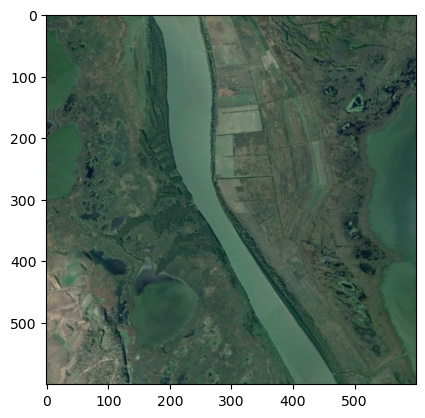

In [5]:
plt.imshow(data["River"][10])
plt.show()

In [6]:
resnet_obj = ResNet()

In [7]:
output = resnet_obj.process_im(data["River"][10])
type(output), output.shape

(numpy.ndarray, (2048,))

In [8]:
# vgg_class_obj = VGG(feature_version=False)
# output = vgg_class_obj.process_im(data["River"][10])
# type(output), output.shape

(numpy.ndarray, (1000,))

In [9]:
vgg_feat_obj = VGG(feature_version=True)
output = vgg_feat_obj.process_im(data["River"][10])
type(output), output.shape

(numpy.ndarray, (1000,))

In [10]:
eff_obj = EffNet()
output = eff_obj.process_im(data["River"][10])
type(output), output.shape

(numpy.ndarray, (1280,))

In [24]:
model_weights = ResNet101_Weights.IMAGENET1K_V2
model = resnet101(weights=model_weights)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
model_weights = VGG16_Weights.IMAGENET1K_V1
model = vgg16(weights=model_weights)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
model_weights = VGG16_Weights.IMAGENET1K_FEATURES
model = vgg16(weights=model_weights)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
#nn.Sequential(*list(model.classifier.children())[:-3])
temp_list = []
for i, child in enumerate(model.children()):
    #print(i)
    #print(child)
    if i == 0 or i == 1:
        temp_list.append(child)
    elif i == 2:
        temp_list.append(child[:-3])
    #print("")
temp_list

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): ReLU(inplace=True)
   (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (3): ReLU(inplace=True)
   (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (6): ReLU(inplace=True)
   (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (8): ReLU(inplace=True)
   (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (11): ReLU(inplace=True)
   (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (13): ReLU(inplace=True)
   (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (15): ReLU(inplace=True)
   (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (17): Conv2d(

In [42]:
temp_list = list(model.children())[:-1]
temp_list

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): ReLU(inplace=True)
   (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (3): ReLU(inplace=True)
   (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (6): ReLU(inplace=True)
   (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (8): ReLU(inplace=True)
   (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (11): ReLU(inplace=True)
   (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (13): ReLU(inplace=True)
   (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (15): ReLU(inplace=True)
   (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (17): Conv2d(

In [43]:
list(model.children())[-1][:-3]

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
)

In [44]:
temp_list = list(model.children())[:-1]
temp_list.append(list(model.children())[-1][:-3])
test_slice = nn.Sequential(*temp_list)
test_slice

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
model_slice = slice_model(model, to_layer=-1).to("cpu")
model_slice

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [31]:
model_weights = EfficientNet_V2_M_Weights.IMAGENET1K_V1
model = efficientnet_v2_m(weights=model_weights)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [32]:
temp_model = nn.Sequential(*list(model.children())[:-1])
temp_model

Sequential(
  (0): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
           

In [33]:
proc_im = eff_obj.preprocess_im(data["River"][10])

temp_out = temp_model(proc_im.unsqueeze(0).to("cpu")).squeeze()
temp_out.detach().numpy().shape

(1280,)

In [ ]:
resnet101_model_weights = ResNet101_Weights.IMAGENET1K_V2
resnet101_model = resnet101(weights=resnet101_model_weights)
# resnet101_model.eval()
resnet101_model_preprocess = resnet101_model_weights.transforms()

In [ ]:
def retype_image(in_img):
    if np.max(in_img) > 1:
        in_img = in_img.astype(np.uint8)
    else:
        in_img = (in_img * 255.0).astype(np.uint8)
    return in_img

In [ ]:
test_im = data["River"][10]
print(type(test_im), test_im.shape)
test_im_retyped = retype_image(test_im)
print(type(test_im_retyped), test_im_retyped.shape)
img_transformed = resnet101_model_preprocess(Image.fromarray(test_im_retyped))
print(type(img_transformed), img_transformed.shape)

In [ ]:
img_transformed.unsqueeze(0).to('cpu').shape

In [ ]:
output1 = resnet101_model(img_transformed.unsqueeze(0).to('cpu')).squeeze()
print(type(output1), output1.shape)

In [ ]:
print(summary(resnet101_model, torch.zeros(size=(1, 3, 224, 224))))

In [ ]:
# get the network without the classification layer
# Drop the output layer (the ImageNet classifier)

def slice_model(original_model, from_layer=None, to_layer=None):
    return nn.Sequential(*list(original_model.children())[from_layer:to_layer])

In [ ]:
resnet101_model_conv_features = slice_model(resnet101_model, to_layer=-1).to('cpu')

In [ ]:
output2 = resnet101_model_conv_features(img_transformed.unsqueeze(0).to('cpu')).squeeze()
print(type(output2), output2.shape)

In [ ]:
print(summary(resnet101_model_conv_features, torch.zeros(size=(1, 3, 224, 224))))

In [ ]:
resnet101_model_conv_features

The inference transforms are available at ResNet101_Weights.IMAGENET1K_V2.transforms and perform the following preprocessing operations: Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. The images are resized to resize_size=[232] using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[224]. Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].

In [ ]:
vgg16_classifier_model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

The inference transforms are available at VGG16_Weights.IMAGENET1K_V1.transforms and perform the following preprocessing operations: Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. The images are resized to resize_size=[256] using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[224]. Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].

In [ ]:
vgg16_features_model = vgg16(weights=VGG16_Weights.IMAGENET1K_FEATURES)

The inference transforms are available at VGG16_Weights.IMAGENET1K_FEATURES.transforms and perform the following preprocessing operations: Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. The images are resized to resize_size=[256] using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[224]. Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.48235, 0.45882, 0.40784] and std=[0.00392156862745098, 0.00392156862745098, 0.00392156862745098].

In [ ]:
efficientnet_model = efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.IMAGENET1K_V1)

The inference transforms are available at EfficientNet_V2_M_Weights.IMAGENET1K_V1.transforms and perform the following preprocessing operations: Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. The images are resized to resize_size=[480] using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[480]. Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].